#Modelling and exploring Leone Allacci's _Drammaturgia_

Code and data for a submission to AIUCD 2024.


## 1. Modellation

In [1]:
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

### Information retrieval

#### Title and subtitle

In [2]:
def extract_title(sentence):
    # Find the first element in the sentence up to the full stop
    match = re.search(r'[^.]*\.', sentence)

    if match:
        # Extract the matched text
        matched_text = match.group().strip(".")

        # Check for the presence of "ovvero" or "o sia"
        if "ovvero" in matched_text or "o sia" in matched_text:
            # Split the text into title and subtitle
            title, _, subtitle = re.split(r'\s*(ovvero|o sia|o siano)\s*', matched_text, maxsplit=1)
            title = title.strip()
            subtitle = subtitle.strip()
            if title.endswith:
              title = title.strip(",")
            if subtitle.startswith(", "):
              subtitle = subtitle[2:]
            return title.title(), subtitle.title()
        else:
            # If "ovvero" or "o sia" is not present, set subtitle_one to None
            title = matched_text.strip()
            return title.title(), None
    else:
        return None, None

In [3]:
# test
test = "SUPERBIA ABBATTUTA NEL TRIONFO DI ESTER, o sia, il Re. — in Roma, per il Buagni, 1706 in 12 — cogli altri Drammi dell'Autore. — di Arcangelo Spagna. "
extract_title(test)

('Superbia Abbattuta Nel Trionfo Di Ester', 'Il Re')

#### Genre

In [4]:
def extract_genre(sentence):
    # Find the first full stop in the sentence
    first_full_stop_match = re.search(r'(?<!\b[SIVX])\.', sentence)

    if first_full_stop_match:
        # Find the second full stop or a parenthesis in the remaining text
        second_full_stop_match = re.search(r'\.|\(', sentence[first_full_stop_match.end():])

        if second_full_stop_match:
            # Extract text from the first full stop to the second full stop
            text_after_full_stop = sentence[first_full_stop_match.end():first_full_stop_match.end() + second_full_stop_match.end()]
            genre = text_after_full_stop.strip().strip(".|(")

            # Keep only the first two words of the genre
            genre_words = genre.split()
            genre = ' '.join(genre_words[:2])

            genre = genre.replace(" di","")
            genre = genre.replace(" per","")
            genre = re.sub(r' recitata| recitato| rappresentata| rappresentato', '', genre)
            genre = genre.strip()

            if genre == 'Op':
                genre = 'Opera'
            if genre.startswith('Rappresentata'):
                genre = 'Unknown'
            elif genre.startswith('in') or genre.startswith('— in'):
                genre = 'Unknown'
            return genre
    else:
        return None

In [5]:
# test
test = "ACCOPPIO ARMONICO DI I. CECILIA CON S. FILIPPO NERI. in Dramma rappresentata in cui ricorse la Festa della medesima Santa, e si aprì il nuovo Oratorio di esso in Perugia l'anno 1689. Dedicato a Monsign. Illustrissimo, e Reverendiss. Luc'Alberto Patrizi, Vescovo di essa Città. — in Perugia per il Costantini. 1689 in 4 — Poesia d'incerto Autore"
extract_genre(test)

'Unknown'

#### Mode

In [6]:
def extract_mode(entry):
    mode = None

    if 'prosa' in entry.lower():
        mode = 'prose'
    elif 'versi' in entry.lower() or 'ottava rima' in entry.lower():
        mode = 'verse'

    return mode

#### Location

In [7]:
def extract_location(entry):

    # check for "Senza luogo" outside the loop
    if "senza luogo" in entry:
        return "Unknown"

    # let's temporarily remove expressions which confuse the parser

    strings = ["in prosa", "in versi", "in due", "in quattro",
               "in ottava", "in terza", "in terzine", "in forma",
               "in luce", "in atto", "in cinque", "in musica",
               "in Musica", "in occasione", "in verso", "in lingua",
               "in Lingua", "in tre", "in Amore", "in data", "in una",
               "in Italiano", "in terzetti", "in Atti", "in S.",
               "in Casa", "in applauso", "in un", "in cui", "in onore",
               "recitato in", "rappresentato in"]  # we remove also what points to staging location
    for string in strings:
      if string in entry:
        entry = entry.replace(string, "")

    # remove uppercase words
    entry = re.sub(r'IN [A-Z]+', '', entry)

    location_pattern = re.compile(r'(?i)in\s([^\s\d]+)')
    match = location_pattern.search(entry)

    location = match.group(1) if match else None
    if location:
      location = location.strip(",")
      location = location.strip(".")
      if location in ["Ven", "Venez","Vinegia"]:
        location = "Venezia"
      if "." in location:
        location.replace(".","")
    return location

In [8]:
test = "ACCIDENTI DEL VITTORIOSO GOFFREDO IN SORTE. Scenario. — in Bologna.,"
extract_location(test)

'Bologna'

####Publisher

In [9]:
def extract_publisher(entry):

    # Let's temporarily remove misdirections from the entry
    strings = ["per Musica","per comando", "di Personaggi"]
    for string in strings:
      if string in entry:
        entry = entry.replace(string, "")

    # Check for "Senza Stampatore" outside the loop
    if "senza Stampatore" in entry or "senza nome di Stampatore" in entry :
        return "Unknown"
    if "e Stampatore" in entry or ", Stampatore" in entry :
        return "Unknown"

    # Define sets of publisher expressions within the function
    pointer_sets = [
        ("per il ", "per gli ", "presso il ", "presso gli ", "nella Stamperia del "),
        ("per ", "pel ", "presso ", "appr\. ", "nella Stamperia ", "nella Stampa "),
        ("appresso ","ad istanza del ", "ad istanza di ", "all'Insegna ")
    ]

    # Iterate through each set of pointers
    for pub_pointers in pointer_sets:
        # Combine the current set of pointers into a regex pattern
        pub_pattern_str = '|'.join(pub_pointers)
        publisher_pattern = re.compile(fr'(?i)\b(?:{pub_pattern_str})\s*([^.,]+)[.,]')

        # Use the regex pattern to search for a match in the input string
        match = publisher_pattern.search(entry)

        # If a match is found, extract and return the publisher information
        if match:
            if "Gio." in match.group(0):
                # Take the following two words as the publisher
                publisher_words = re.findall(r'\b\w+\b', entry)
                publisher_index = publisher_words.index("Gio") + 1
                return ' '.join(publisher_words[publisher_index: publisher_index + 2])
            else:
                # Extract and return the publisher information
                publisher = match.group(1).strip()
                if publisher.startswith("l'"):
                    publisher = publisher[2:]  # Remove "l'"
                if publisher == "Pietro Van":
                  publisher = "Pietro Van Ghelen"
                if publisher == "Niccolini":
                  publisher = "Francesco Niccolini"
                return publisher

    # If no match is found in any set of pointers, return None
    return None

In [10]:
test = "PERUGINA. Orazione Sacra per Musica. senza Nome, per l'Ertz."
extract_publisher(test)

'Ertz'

####Year

In [11]:
def extract_year(entry):

    # check for "Senza anno" outside the loop
    if "senz'anno" in entry.lower() or "senza anno" in entry.lower() or "re, ed anno" in entry.lower():
        return "Unknown"

    # Define the pattern for finding the year followed by "in"
    year_pattern = re.compile(r'(\d{4})\s*in', re.IGNORECASE)

    # Search for the pattern in the input string
    match = year_pattern.search(entry)

    # If the pattern is found, return the matched year
    if match:
        year = int(match.group(1))
        return year
    else:
        # If the pattern is not found, try finding any year pattern
        general_year_pattern = re.compile(r'(\d{4})')
        general_match = general_year_pattern.search(entry)
        general_year = int(general_match.group(1)) if general_match else None
        return general_year

In [12]:
test = "ALARICO RE DE' GOTI. Dramma recitato in Ferrara 1876. nel Teatro Bonacossi. senza Stampatore"
extract_year(test)

1876

####Format

In [13]:
def extract_format(entry):
    format_pattern = re.compile(r'in\s(\d+)')
    match = format_pattern.search(entry)
    format = match.group(1) if match else None
    return format

In [14]:
test = "ALARICO. Drama rappresentato nel Teatro Obizzi di Padova l'anno 1709 in Padova, senza Stampatore, 1709 in 12 — 1679 in 4 Poesia d'Incerto."
extract_format(test)

'12'

####Author

In [15]:
def extract_author(entry):

    # Check for "incerto" outside the loop
    if "incerto" in entry.lower():
        return "Unknown"

    # titles and honorifics to be removed
    titles = ["Co. ","Conte ","Ab. ","Abate ", "P. ", "Padre", "Fr. ", "Monsign. ",
              "Don ", "Dott. ", "Dottore ", "Dottor ", "D. ", "Fra ", "F. ", "Marchese "]

    # Define the pattern for capturing two words after dash and "di" or "Poesia di"
    author_pattern = re.compile(r'(?:— di|— da|— del[l\']|— del|— dal|Poesia di|Poesia del)\s*([^,]+ [^,]+)')

    # Search for the pattern in the input string
    match = author_pattern.search(entry)

    # If the pattern is found, return the matched author
    if match:
        author = match.group(1).strip()
        # remove titles
        for title in titles:
          if title in author:
            author = author.replace(title, "")
        # fix residual issues
        author = re.sub(r'\. — .*$', '', author)
        author = author.strip(".,")
        if author.startswith("l'"):
            author = author.replace("l'", "")
        if author.startswith("l "):
            author = author[2:]
        if author.startswith("'"):
            author = author.replace("'", "")
        if author.endswith("."):
          author = author.replace(".", "")
        if author.startswith("Polisseno Fegejo Pastor Arcade"):
                author = "Carlo Goldoni"
        return author
    else:
        return None

In [16]:
test = "ALARICO. Drama — di Donato Cupeda. — Musica di Gio. Bononcini."
extract_author(test)

'Donato Cupeda'

####Libretto

In [17]:
def check_if_libretto(entry):
    libretto = None

    if 'musica di' in entry.lower():
        libretto = True
    else:
        libretto = False

    return libretto

In [18]:
t = "Esampio di balb la Music di"
check_if_libretto(t)

False

####Translation

In [19]:
def check_if_translation(entry):
    translation = None

    if 'tradot' in entry.lower() or "traduz" in entry.lower():
        translation = True
    else:
        translation = False

    return translation

###Database building

In [20]:
url = 'https://raw.githubusercontent.com/allacci-digitale/allacci-digitale.github.io/main/data/cleaned-transcription.txt'
response = requests.get(url).text
entries = response.split('\n')

# Create a DataFrame
df = pd.DataFrame({"entry": entries})

In [21]:
# extract info and fill the df

df['title'], df['subtitle'] = zip(*df['entry'].apply(extract_title))
df['author'] = df['entry'].apply(extract_author)
df['genre'] = df['entry'].apply(extract_genre)
df['mode'] = df['entry'].apply(extract_mode)
df['location'] = df['entry'].apply(extract_location)
df['publisher'] = df['entry'].apply(extract_publisher)

df['year'] = df['entry'].apply(extract_year)
df['year'] = pd.to_numeric(df['year'], errors='coerce')

df['format'] = df['entry'].apply(extract_format)
df['libretto'] = df['entry'].apply(check_if_libretto)
df['translation'] = df['entry'].apply(check_if_translation)

# Display the resulting DataFrame
df.head(5)

,entry,title,subtitle,author,genre,mode,location,publisher,year,format,libretto,translation
0,ABBAGLI FELICI. Commedia (in prosa). — In Mace...,Abbagli Felici,None,Prospero Bonarelli della Rovere,Commedia,prose,Macerata,Agostino Grisei,1642.0,12,False,False
1,ABBANDONO D'ARMIDA. Trattenimento scenico cant...,Abbandono D'Armida,None,Giovanni Boldini,Trattenimento scenico,verse,Venezia,Carlo Buonarrigo,1729.0,12,True,False
2,ABBATE. Commedia (in prosa). — in Venez. appre...,Abbate,None,Bartolommeo Cappello,Commedia,prose,Venezia,Agostino Bindoni,1556.0,8,False,False
3,ABBISAI. Op. (in prosa). — in Milano per il Ma...,Abbisai,None,Carlo Giuseppe Cornacchia,Opera,prose,Milano,Malatesta,1718.0,12,False,False
4,ABDOLOMINO. Dramma rappresentato alle Sac. Ces...,Abdolomino,None,Silvio Stampiglia,Dramma,None,Vienna,gli Eredi Cosmeroviani,1709.0,8,True,False


#### Debug

In [22]:
# debug nones

none_entries = df.loc[df['author'].isnull(), 'entry']

for entry in none_entries:
    print(entry)

ACARNE. Commedia di Aristofane tradotta dal Greco in Lingua comun d'Italia. — in Vinegia, appr. Vincenzo Valgrisi. 1545 in 8 — di Bartolommeo, e Pietro Fratelli Rositini, da Pratalboino.
ACCIDENTI D'AMORE. Commedia (in prosa). in Ven. appresso Angiol Salvadori. 1635. in 12. dal Dot. Fulvio Genga di Fano.
ADAMIRA, ovvero, la Statua dell'Onore. Opera Scenica (in prosa). — in Ven. appr. Giacomo Batti. / 1657. in 12. — in Perugia, per Sebastian Zecchini, 1659. in 12. — in Venez. per il Pezzana 1662 in 12. — ed in Bologna, per Giacomo Monti. Senz'anno. in 12. E la stessa che l'Amore nella Statua, di Giacinto Andrea Cicognini, Fiorentino.
ADARCONTE. Tragedia (in prosa). — in Roma, per Michiel Ercole. 1676.
ADONE. Pastorale Drammatica. — in Napoli, per Tarquinio Longo. 1614. in 4. con le altre Poesie dell'Autore— Poesia di Marcello—Macedonio.
ADRIANO. Tragedia di Giuseppe Squillaci, di Catania.
ALBIDO. Favola Pastorale. — in Roma, per Giacomo Mascardi, 1624 in 12. — ed ivi, per Lodovico Grigh

In [23]:
# debug strange stuff
unique_values = df['location'].value_counts()
sorted_values = unique_values.sort_values(ascending=False)
for value, frequency in sorted_values.items():
  #if type(value) == int and value < 1500:
  print(f"{value}: {frequency}")

Venezia: 1853
Bologna: 509
Roma: 359
Napoli: 358
Firenze: 352
Vienna: 244
Palermo: 208
Siena: 200
Milano: 161
Ferrara: 93
Viterbo: 92
Padova: 91
Verona: 75
Mantova: 58
Vicenza: 55
Macerata: 52
Parma: 51
Modona: 46
Unknown: 42
Genova: 41
Ronciglione: 41
Perugia: 36
Lucca: 33
Brescia: 31
Torino: 30
Lipsia: 30
Fiorenza: 26
Messina: 24
Ancona: 24
Trevigi: 19
Orvieto: 18
Reggio: 17
Cremona: 16
Arezzo: 16
Terni: 15
Udine: 14
Catania: 14
Monaco: 14
Pisa: 13
Urbino: 13
Belluno: 13
Piacenza: 12
Piazzola: 12
Parigi: 11
Pavia: 11
Foligno: 10
Bergamo: 10
Bracciano: 9
Pesaro: 9
Todi: 8
Serravalle: 8
Trani: 7
Modena: 7
Venetia: 6
Pratolino: 6
Trapani: 6
Rovigo: 5
Livorno: 5
Cesena: 5
Bassano: 5
Fermo: 5
Rimini: 4
Faenza: 4
Fano: 4
Città: 4
Colonia: 4
Lodi: 4
Versi: 4
Cossenza: 3
fine: 3
Ascoli: 3
Carmagnola: 3
volgare: 3
Grimani: 3
Londra: 3
Gubbio: 3
Commedia: 3
lode: 3
Roma): 3
Benevento: 3
Velletri: 3
Volgare: 3
San: 3
Ravenna: 3
Guastalla: 2
tempo: 2
quella: 2
nuovo: 2
istile: 2
Favola: 2
Ispruc

In [24]:
# find recurrent empty fields

for column in df.columns:
    none_count = df[column].apply(lambda x: x is None).sum()
    total_entries = len(df[column])
    percent_none = ((none_count / total_entries) * 100 if total_entries > 0 else 0).round(2)
    print(f"In the '{column}' column there are {none_count} None values out of {total_entries} ---> {percent_none}")

In the 'entry' column there are 0 None values out of 6076 ---> 0.0
In the 'title' column there are 0 None values out of 6076 ---> 0.0
In the 'subtitle' column there are 5750 None values out of 6076 ---> 94.63
In the 'author' column there are 325 None values out of 6076 ---> 5.35
In the 'genre' column there are 6 None values out of 6076 ---> 0.1
In the 'mode' column there are 4026 None values out of 6076 ---> 66.26
In the 'location' column there are 220 None values out of 6076 ---> 3.62
In the 'publisher' column there are 408 None values out of 6076 ---> 6.71
In the 'year' column there are 0 None values out of 6076 ---> 0.0
In the 'format' column there are 246 None values out of 6076 ---> 4.05
In the 'libretto' column there are 0 None values out of 6076 ---> 0.0
In the 'translation' column there are 0 None values out of 6076 ---> 0.0


#### Export database

In [29]:
df.to_csv("database.csv")
df.to_json("database.json")

##2. Exploratory data analysis

In [26]:
count_entries = ((df['year'] >= 1561) & (df['year'] <= 1710)).sum()
print("Number of texts between 1561 and 1710:", count_entries)

Number of texts between 1561 and 1710: 3816


In [27]:
def visualise(info, plot_type):
    filtered_df = df[df[info].notna() & (df[info] != "Unknown")]

    # Get the top 15 entries sorted by frequency
    top_15_values = filtered_df[info].value_counts().head(15)

    # Print the top 15 values and their frequencies
    for value, frequency in top_15_values.items():
        print(f"{value}: {frequency}")

    # Create a DataFrame for the top 15 values
    top_15_df = filtered_df[filtered_df[info].isin(top_15_values.index)]

    # Sort values by frequency in descending order
    sorted_values = top_15_df[info].value_counts().index

    # Dynamically call the specified plot method
    getattr(plt, plot_type)(sorted_values, top_15_df[info].value_counts(),
                            color='darkred', edgecolor='black')

    plt.xlabel(f"{info}")
    plt.ylabel('frequency')

    # Set x-axis ticks and labels based on sorted order of frequencies
    plt.xticks(sorted_values, [f'{value}' for value in sorted_values], rotation=90, ha="right")

    plt.show()

Apostolo Zeno: 125
Niccolò Minato: 73
Francesco Silvani: 72
Carlo Goldoni: 72
Pietro Metastasio: 55
Giacinto Andrea Cicognini: 47
Matteo Noris: 41
Ortensio Scamacca: 38
Pier Jacopo Martello: 33
Aurelio Aurelj: 31
Antonio Salvi: 30
Girolamo Gigli: 26
Arcangelo Spagna: 25
Domenico Lalli: 21
Girolamo Bartolommei: 20


ConversionError: Failed to convert value(s) to axis units: Index(['Apostolo Zeno', 'Niccolò Minato', 'Francesco Silvani', 'Carlo Goldoni',
       'Pietro Metastasio', 'Giacinto Andrea Cicognini', 'Matteo Noris',
       'Ortensio Scamacca', 'Pier Jacopo Martello', 'Aurelio Aurelj',
       'Antonio Salvi', 'Girolamo Gigli', 'Arcangelo Spagna', 'Domenico Lalli',
       'Girolamo Bartolommei'],
      dtype='object', name='author')

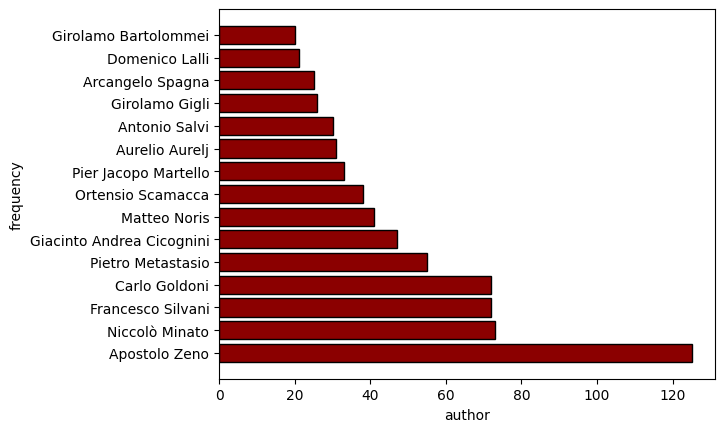

In [28]:
visualise('author',plot_type="barh")

In [ ]:
# plot locations

data = {'Venezia': 1814, 'Bologna': 517, 'Roma': 359, 'Napoli': 358, 'Firenze': 351,
        'Vienna': 241, 'Palermo': 208, 'Siena': 195, 'Milano': 159, 'Ferrara': 91,
        'Viterbo': 90, 'Padova': 87, 'Verona': 74, 'Mantova': 56, 'Vicenza': 55,
        'Macerata': 52, 'Parma': 49, 'Modena': 46, 'Ronciglione': 40, 'Genova': 38,
        'Lucca': 34, 'Perugia': 32, 'Brescia': 31, 'Torino': 30, 'Lipsia': 30}

# Simplified dataset of city coordinates (latitude, longitude)
city_coordinates = {
      'Venezia': (45.4408474, 12.3155151),
      'Bologna': (44.494887, 11.342616),
      'Roma': (41.9027835, 12.4963655),
      'Napoli': (40.852162, 14.2681103),
      'Firenze': (43.7695604, 11.2558136),
      'Vienna': (48.2083537, 16.3725042),
      'Palermo': (38.1157, 13.3615),
      'Siena': (43.3186, 11.3307),
      'Milano': (45.4642, 9.1900),
      'Ferrara': (44.8350, 11.6180),
      'Viterbo': (42.4174, 12.1047),
      'Padova': (45.4064, 11.8768),
      'Verona': (45.4384, 10.9916),
      'Mantova': (45.1569, 10.7910),
      'Vicenza': (45.5455, 11.5350),
      'Macerata': (43.3000, 13.4532),
      'Parma': (44.8015, 10.3279),
      'Modena': (44.6471, 10.9252),
      'Ronciglione': (42.2711, 12.1987),
      'Genova': (44.4056, 8.9463),
      'Lucca': (43.8420, 10.5027),
      'Perugia': (43.1107, 12.3890),
      'Brescia': (45.5416, 10.2118),
      'Torino': (45.0703, 7.6869),
      'Lipsia': (51.3432, 12.3809)
}

# Create a map centered around Italy
m = folium.Map(location=[41.8719, 12.5674], zoom_start=4)

# Add markers for each city with the size proportional to the number of events
for city, events in data.items():
    coordinates = city_coordinates.get(city)
    if coordinates:
        folium.CircleMarker(
            location=coordinates,
            radius=events / 50,  # Adjust the scaling factor as needed
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.2,
            popup=f"{city}: {events} events"
        ).add_to(m)

# Display the map in Colab
m

In [ ]:
# print the corpus' diachronic span

filtered_df = df[df['year'].notna() & (df['year'] != "Unknown")]

# Plot histogram
plt.hist(filtered_df['year'], bins=range(1500, 1760, 10), color="darkgreen", edgecolor='black')

# Set major labels every 50 years
major_labels = range(1500, 1760, 10)
plt.xticks(major_labels, rotation=90)

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('No. of works')

# Show the plot
plt.show()

## Trashbin/drafts

In [ ]:
# after the tab is clean enough, we will generate slugs for easier work identification
'''
def generate_slug(row):
    author_words = row['author'].split() if row['author'] else ['UnknownAuthor']
    title_word = row['title'].split()[0] if row['title'] else 'UnknownTitle'

    first_word = next((word for word in author_words if len(word) >= 4), author_words[0])

    return f"{first_word}-{title_word}"

df['slug'] = df.apply(generate_slug, axis=1)
'''

In [ ]:
'''
# Add a new column 'Length' representing the length of each entry
df['entry_length'] = df['full_entry'].apply(len)

# Filter entries with length less than 1000
df_filtered = df[df['entry_length'] < 1000]

# Create a histogram to visualize the distribution of entry lengths
plt.hist(df_filtered['entry_length'], bins=100, edgecolor='black')
plt.title('Distribution of Entry Lengths (Length < 1000)')
plt.xlabel('Length of Entries')
plt.ylabel('Frequency')
plt.show()
'''

In [ ]:
'''
# Sort the DataFrame by the 'Length' column in descending order
df_sorted = df.sort_values(by='Length', ascending=False)

# Print the top 5 entries with the highest length
top_5_entries = df_sorted.head(5)['Full Text']
for i, entry in enumerate(top_5_entries, start=1):
    print(f"Top {i} Entry - Length {len(entry)}:\n{entry}\n{'='*50}\n")
'''